In [ ]:
# clean the outputs env

import shutil
import os

shutil.rmtree('saved_models', ignore_errors=True)
shutil.rmtree('saved_params', ignore_errors=True)
shutil.rmtree('saved_results', ignore_errors=True)

os.mkdir('saved_models/')
os.mkdir('saved_params/')
os.mkdir('saved_results/')

shutil.rmtree('outputs', ignore_errors=True)
os.mkdir('outputs/')
os.mkdir('outputs/yeast/')

Evaluation result of Eval dataset: Total Loss= 8855.7741, Total L1 Loss= 1243.0989
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Predict Result Profile of 315 Queries:
Min/Max: -17.3414 / 23.0142
Mean: 0.9596
Median: 0.5862
25%/75% Quantiles: -2.2858 / 3.8192
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


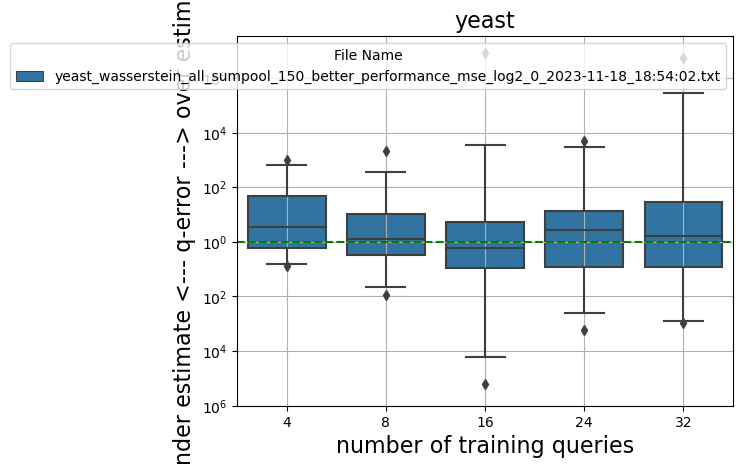

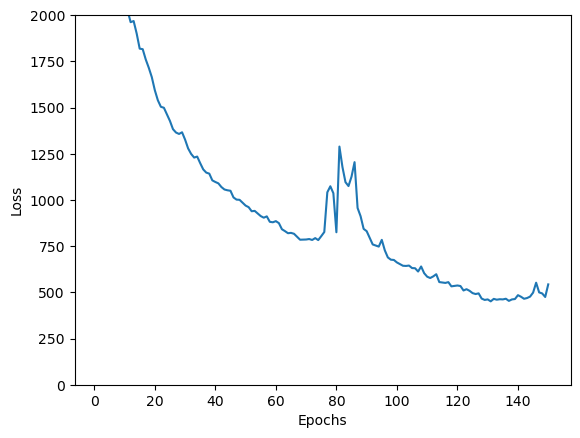

In [68]:
# draw figures for NeurSC results

import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

def get_prediction_statistics(errors: list):
	lower, upper = np.quantile(errors, 0.25), np.quantile(errors, 0.75)
	print("<" * 80, flush=True)
	print("Predict Result Profile of {} Queries:".format(len(errors)), flush=True)
	print("Min/Max: {:.4f} / {:.4f}".format(np.min(errors), np.max(errors)), flush=True)
	print("Mean: {:.4f}".format(np.mean(errors)), flush=True)
	print("Median: {:.4f}".format(np.median(errors)), flush=True)
	print("25%/75% Quantiles: {:.4f} / {:.4f}".format(lower, upper), flush=True)
	print(">" * 80, flush=True)
	error_median = abs(upper - lower)
	return error_median

def interperting_results(file_names):
    results_dir = './saved_results/'
    
    trans_func = lambda x: x
    # trans_func = math.log2

    all_results = []
    for file in file_names:
        results = {} # results <- {name: [pred, true]}
        with open(results_dir + file) as f:
            for line in f.readlines()[1:]:
                line = line.strip()
                tokens = line.split(' ')
                results[tokens[0]] = [float(tokens[2]), float(tokens[3])]
        all_results.append(results)

    for results in all_results:
        if len(results) == 0:
            continue
        q_errors = []
        total_square_loss = 0
        total_l1_loss = 0
        count = 0
        for pred, card in results.values():
            if pred == 0:
                pred = 1
            pred = trans_func(pred)
            card = trans_func(card)
            q_errors.append(pred - card)
            total_square_loss += (pred - card)**2
            total_l1_loss += abs(pred - card)
            count += 1
        print("Evaluation result of Eval dataset: Total Loss= {:.4f}, Total L1 Loss= {:.4f}".format(total_square_loss, total_l1_loss))
        get_prediction_statistics(q_errors)

def read_result_file(result_dir, result_name):
    # model_data = [['File Name', 'Epochs', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'], [...], ...]
    name_tokens = result_name.split('_')
    epochs = int(name_tokens[4])
    res = []

    with open(result_dir + result_name, 'r') as f:
        for line in f.readlines()[1:]:
            line_tokens = line.split()
            query_name_tokens = line_tokens[0].split('.')[0].split('_')
            query_size = int(query_name_tokens[2])
            query_type = query_name_tokens[1]
            pred = float(line_tokens[2]) * math.log10(2)
            card = float(line_tokens[3]) * math.log10(2)
            q_error = float(line_tokens[1]) * math.log10(2)
            res.append([result_name, epochs, query_size, query_type, pred, card, q_error])
    return res

def read_train_file(outputs_dir, output_name):
    # res = [['File Name', 'Epochs', 'Loss']]
    res = []
    with open(outputs_dir + output_name, 'r') as f:
        for line in f.readlines():
            if line.startswith('Epoch '):
                tokens = line.split(' ')
                epoch = int(tokens[1].split('/')[0])
                loss = float(tokens[-1])
                res.append([output_name, epoch, loss])
    return res

def draw_box_plot(dataframe, title, fontsize=16):
    bp = sns.boxplot(data=dataframe, x='Query Size', y='q-error', whis=[1, 99], hue='File Name')
    plt.title(title, fontsize=fontsize)
    plt.grid(True)
    plt.axhline(0, color='green',linestyle='dashed')
    plt.ylabel('Under estimate <--- q-error ---> Over estimate', fontsize=fontsize)
    plt.xlabel('Query Size', fontsize=fontsize)
    if title == 'yeast':
        plt.yticks(ticks=[-6, -4, -2, 0, 2, 4, 6], 
                   labels=['$10^6$', '$10^4$', '$10^2$', '$10^0$', '$10^2$', '$10^4$', '$10^6$'])
    elif title == 'youtube':    
        plt.yticks(ticks=[-8, -6, -4, -2, 0, 2, 4, 6, 8], 
                   labels=['$10^8$', '$10^6$', '$10^4$', '$10^2$', '$10^0$', '$10^2$', '$10^4$', '$10^6$', '$10^8$'])
    elif title == 'wordnet':
        plt.yticks(ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], 
                   labels=['$10^5$', '$10^4$', '$10^3$', '$10^2$', '$10^1$', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'])
    elif title == 'eu2005':
        plt.yticks(ticks=[-3, -2, -1, 0, 1, 2, 3], 
                   labels=['$10^3$', '$10^2$', '$10^1$', '$10^0$', '$10^1$', '$10^2$', '$10^3$'])
    else:
        raise Exception('Not recognized dataset')
    plt.ylabel('under estimate <--- q-error ---> over estimate')
    plt.xlabel('number of training queries')
    # pcntls = df.groupby('Query Size')['q-error'].describe(percentiles=[0.1, 0.9])
    # pcntls = pcntls.sort_values(by='Query Size')
    # columns = len(pcntls['10%'])
    # bp.scatter(data=pcntls, x=range(columns), y='10%', marker='x')
    # bp.scatter(data=pcntls, x=range(columns), y='90%', marker='x')
    plt.show()

def draw_line_plot(df, title):
    bp = sns.lineplot(data=df, x='Epochs', y='Loss')
    plt.ylim((0, 2000))

if __name__ == '__main__':
    data_graph = 'yeast'
    result_dir = 'saved_results/'
    params_dir = 'saved_params/'
    file_names = ['yeast_wasserstein_all_sumpool_150_better_performance_mse_log2_0_2023-11-18_18:54:02.txt']
    interperting_results(file_names)
    
    # model_data = [['Epochs', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'], [...], ...]
    test_data = []
    for file_name in file_names:
        test_data.extend(read_result_file(result_dir, file_name))
    df = pd.DataFrame(data=test_data, 
                      columns=['File Name', 'Epochs', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'])
    df = df.sort_values(by='Query Size')        
    draw_box_plot(df, data_graph)

    # draw the loss_epoch figure
    outputs_dir = 'outputs/{}/'.format(data_graph)
    output_names = ['150_better_performance_mse_log2_0.txt']
    train_data = []
    for output_name in output_names:
        train_data.extend(read_train_file(outputs_dir, output_name))
    df = pd.DataFrame(data=train_data, 
                      columns=['File Name', 'Epochs', 'Loss'])
    draw_line_plot(df, data_graph)